## **Predicting Credit Card Approvals**

Most commerical banks will receive plenty of applications for credit cards. Rejections can be due to factors such as high loan balances, low income level, low credit score etc. Manually analyzing these applications is mundane, error-prone, and time-consuming. 

Objective: In this notebook, we will be trying to build an automatic credit card approval predictor using machine learning techniques.

We will be using the [Credit Card Approval](https://archive.ics.uci.edu/ml/datasets/credit+approval) dataset from the [UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/), which is a collection of credit card applications and the credit approval decisions.

Dataset used with reference to Quinlan, Quinlan. Credit Approval. UCI Machine Learning Repository.

### **Import Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### **Load Dataset**

In [2]:
# Load the dataset
cc_apps_master = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', header=None)

# Preview data
cc_apps_master.info()
cc_apps_master.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      690 non-null    object 
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


### **Inspecting Data**

The nature of the output is confusing due to the data being anonymised to protect the individual applicant's privacy. The [codebook](https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.names) available here clearly shows the features of the dataset, which we will assign to working variables to make working with the data easier and more convenient. We will use the column names as referenced in this [blog post](https://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html) and assign the names accordingly.

In [3]:
# Rename the columns of the list 
cc_apps_master.columns = ['Male',
                   'Age',
                   'Debt',
                   'Married',
                   'BankCustomer',
                   'EducationLevel',
                   'Ethnicity',
                   'YearsEmployed',
                   'PriorDefault',
                   'Employed',
                   'CreditScore',
                   'DriversLicense', 
                   'Citizen', 
                   'ZipCode', 
                   'Income', 
                   'Approved']

# Drop features that should not usually affect the prediction of the respone and save in the working file
cc_apps = cc_apps_master.drop(['DriversLicense', 'ZipCode'], axis='columns')

# Preview data
cc_apps.head()

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [4]:
# Inspecting the missing values
cc_apps.isna().sum()

Male              0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
Citizen           0
Income            0
Approved          0
dtype: int64

In [5]:
cc_apps.value_counts()

Male  Age    Debt    Married  BankCustomer  EducationLevel  Ethnicity  YearsEmployed  PriorDefault  Employed  CreditScore  Citizen  Income  Approved
?     20.08  0.125   u        g             q               v          1.000          f             t         1            g        768     +           1
b     30.17  6.500   u        g             cc              v          3.125          t             t         8            g        1200    +           1
      29.67  1.415   u        g             w               h          0.750          t             t         1            g        100     +           1
      29.83  1.250   y        p             k               v          0.250          f             f         0            g        0       -           1
             2.040   y        p             x               h          0.040          f             f         0            g        1       -           1
                                                                                 

In [6]:
# View the summary statistics
cc_apps.describe()

,Debt,YearsEmployed,CreditScore,Income
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [7]:
# View count of unique values in each column
for col in cc_apps.columns:
    print('-' * 40 + col + '-' * 40)
    display(cc_apps[col].value_counts().head(10))

----------------------------------------Male----------------------------------------


b    468
a    210
?     12
Name: Male, dtype: int64

----------------------------------------Age----------------------------------------


?        12
22.67     9
20.42     7
18.83     6
24.50     6
25.00     6
19.17     6
22.50     6
20.67     6
23.58     6
Name: Age, dtype: int64

----------------------------------------Debt----------------------------------------


1.50    21
0.00    19
3.00    19
2.50    19
0.75    16
1.25    16
0.50    15
5.00    14
6.50    12
1.75    12
Name: Debt, dtype: int64

----------------------------------------Married----------------------------------------


u    519
y    163
?      6
l      2
Name: Married, dtype: int64

----------------------------------------BankCustomer----------------------------------------


g     519
p     163
?       6
gg      2
Name: BankCustomer, dtype: int64

----------------------------------------EducationLevel----------------------------------------


c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
Name: EducationLevel, dtype: int64

----------------------------------------Ethnicity----------------------------------------


v     399
h     138
bb     59
ff     57
?       9
j       8
z       8
dd      6
n       4
o       2
Name: Ethnicity, dtype: int64

----------------------------------------YearsEmployed----------------------------------------


0.000    70
0.250    35
0.040    33
1.000    31
0.125    30
0.500    28
0.085    26
1.500    25
0.165    22
2.500    17
Name: YearsEmployed, dtype: int64

----------------------------------------PriorDefault----------------------------------------


t    361
f    329
Name: PriorDefault, dtype: int64

----------------------------------------Employed----------------------------------------


f    395
t    295
Name: Employed, dtype: int64

----------------------------------------CreditScore----------------------------------------


0     395
1      71
2      45
3      28
6      23
11     19
5      18
7      16
4      15
9      10
Name: CreditScore, dtype: int64

----------------------------------------Citizen----------------------------------------


g    625
s     57
p      8
Name: Citizen, dtype: int64

----------------------------------------Income----------------------------------------


0       295
1        29
500      10
1000     10
2         9
6         8
5         8
300       8
200       6
100       6
Name: Income, dtype: int64

----------------------------------------Approved----------------------------------------


-    383
+    307
Name: Approved, dtype: int64

As we can see in the above values, certain columns like 'Male' have unknown values marked as '?', which is why is.na() did not catch them. Similarly, the 'Married' column has values 'y' & 'u', which denote either 'Married' or 'Not Married', and an additional value 'l', which is likely an error.

Due to the data being completely anonmised, we shall not clean the incorrect values. However we will clean the '?' values after splitting the data.

### **Exploratory Data Analysis**

<AxesSubplot:xlabel='Income', ylabel='Count'>

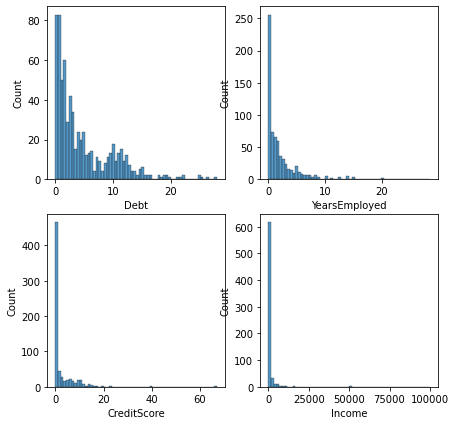

In [8]:
# Viewing spread of the numerical data
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(cc_apps, x='Debt', bins = 60, ax=axs[0, 0])
sns.histplot(cc_apps, x='YearsEmployed', bins = 60, ax=axs[0, 1])
sns.histplot(cc_apps, x='CreditScore', bins = 60, ax=axs[1, 0])
sns.histplot(cc_apps, x='Income', bins = 60, ax=axs[1, 1])

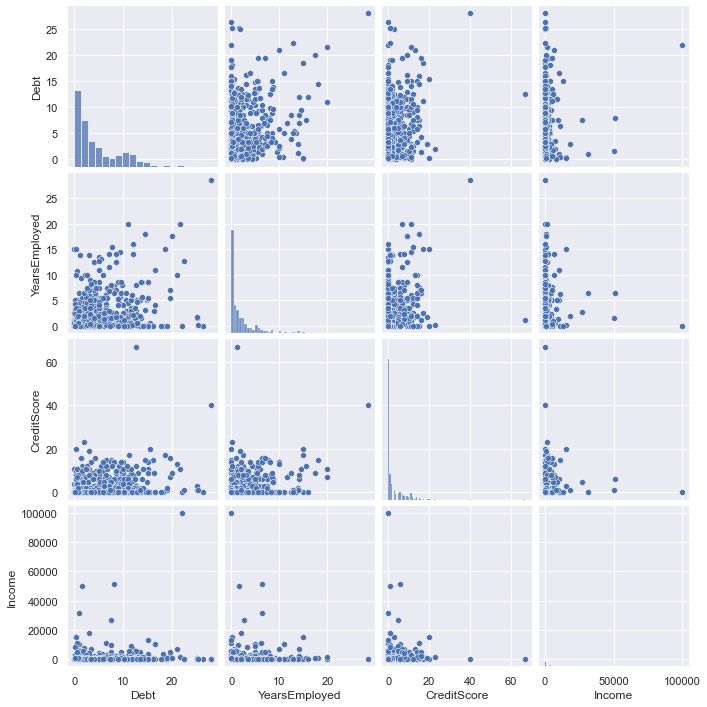

In [9]:
# Viewing for rough correlations between columns 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pairplot(data=cc_apps)

### **Replacing Missing Values in Pandas**

In [10]:
# Replace all instances of '?' with np.NaN
cc_apps.replace('?', np.NaN, inplace=True)

In [11]:
# Splitting the data into the features and response
X = cc_apps.drop('Approved', axis='columns')

y = cc_apps['Approved']

### **Preprocessing with Scikit-Learn**

In [12]:
# Set up preprocessing for numeric columns
imp_mean = SimpleImputer(missing_values=np.NaN, strategy='mean', add_indicator=True) 
scaler = MinMaxScaler(feature_range=(0,1))

In [13]:
# Set up preprocessing for categorical columns
imp_constant = SimpleImputer(missing_values=np.NaN, strategy='most_frequent', add_indicator=True)
ohe = OneHotEncoder(handle_unknown='ignore')

In [14]:
# Seleect columns by data type
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')

In [15]:
# Standard preprocessing
preprocessing = make_column_transformer(
    (make_pipeline(imp_mean, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols))

In [16]:
# Creat pipeline
pipe = make_pipeline(preprocessing, LogisticRegression())

### **Model Evaluation**

In [21]:
# Cross-validate the pipeline
cross_val_score(pipe, X, y, cv=10, scoring='accuracy')

array([0.44927536, 0.8115942 , 0.97101449, 0.92753623, 0.97101449,
       0.92753623, 0.85507246, 0.69565217, 1.        , 0.86956522])

### **Hyperparameter Tuning**

In [18]:
# Define the grid of values for tol and max_iter
params = {}
params['logisticregression__tol'] = [0.01, 0.001 ,0.0001]
params['logisticregression__max_iter'] = [100, 150, 200]

### **Model Re-Evaluation Using GridSearchCV**

In [19]:
# Instantiate GridSearchCV with the required parameters
grid = GridSearchCV(pipe, params, cv=10, scoring='accuracy')

# Fit grid to the data
grid.fit(X, y);

### **Summary**

In [20]:
# Summarise results
best_score, best_params = grid.best_score_, grid.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.847826 using {'logisticregression__max_iter': 100, 'logisticregression__tol': 0.01}
